In [4]:
!wget https://zenodo.org/record/53169/files/Kather_texture_2016_image_tiles_5000.zip
!unzip -o -q Kather_texture_2016_image_tiles_5000.zip

--2020-03-26 01:00:35--  https://zenodo.org/record/53169/files/Kather_texture_2016_image_tiles_5000.zip
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 258098431 (246M) [application/octet-stream]
Saving to: ‘Kather_texture_2016_image_tiles_5000.zip’

Kather_texture_2016 100%[===================>] 246.14M  17.0MB/s    in 16s     

2020-03-26 01:00:52 (15.3 MB/s) - ‘Kather_texture_2016_image_tiles_5000.zip’ saved [258098431/258098431]



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/CS904/CW')
!ls

CS904_CW.ipynb
katherData.h5
katherData_trainTest.h5
Kather_texture_2016_image_tiles_5000
Kather_texture_2016_image_tiles_5000.zip
tcga-a6-5660-01z-00-dx1.b254e383-a889-4b73-8f91-8580c8285754.svs
tcga-az-4614-01z-00-dx1.c1488dfe-528f-4dd4-b5f8-da81fbb4ec0b.svs


# **Task 1:**

In [0]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from skimage.io import imread_collection
import numpy as np
from sklearn.model_selection import train_test_split
import h5py
import cv2
from scipy.stats import moment
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops
from skimage.filters import gabor
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


In [0]:
dataSet = imread_collection('Kather_texture_2016_image_tiles_5000/*/*.tif')

In [11]:
print(dataSet.files[0][37:39])
# generate the label set 1:tumor, 2:stroma, 3:complex, 4:lympho, 5:debris, 6:mucosa, 7:adipose, 8:empty
labelSet = []
for file in dataSet.files:
  if file[37:39] == '01':
    labelSet.append(1)
  elif file[37:39] == '02':
    labelSet.append(2)
  elif file[37:39] == '03':
    labelSet.append(3)
  elif file[37:39] == '04':
    labelSet.append(4)
  elif file[37:39] == '05':
    labelSet.append(5)
  elif file[37:39] == '06':
    labelSet.append(6)
  elif file[37:39] == '07':
    labelSet.append(7)
  elif file[37:39] == '08':
    labelSet.append(8)

print(len(labelSet))
labelSet = np.array(labelSet)


01
5000


In [13]:
# write the dataSet to a h5 file for saving running time
hf = h5py.File('katherData.h5', 'w')
hf.create_dataset('dataSet', data=dataSet)
hf.create_dataset('labelSet', data=labelSet)
hf.close()

/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'reverse_bitorder'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))


In [0]:
# read the dataSet from a h5 file for saving running time
hf = h5py.File('katherData.h5', 'r')
dataSet = hf.get('dataSet')
labelSet = hf.get('labelSet')


In [0]:
encoder = preprocessing.LabelEncoder()
encoder.fit(labelSet)
labelSet_encode = encoder.transform(labelSet)

In [16]:
# get all features form the dataSet
dataSet_features = []
for img in dataSet:
  features = []
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ghist = cv2.calcHist([img_gray], [0], None, [256], [0,256])
  features.append(np.mean(ghist))
  features.append(np.std(ghist))
  features.append(np.sum(ghist))
  features.append(np.mean(moment(ghist, moment=2)))
  features.append(np.mean(local_binary_pattern(img_gray, 24, 3)))
  features.append(np.mean(greycomatrix(img_gray, [3], [45], 256, True, True)))
  features.append(np.mean(gabor(img_gray, 0.6)))
  dataSet_features.append(features)
print(len(dataSet_features))
print(dataSet_features[0])

5000
[87.890625, 145.11617, 22500.0, 21058.7, 8626724.538444445, 1.5258789062500003e-05, 28.32782222222222]


In [17]:
# transfer the list to np array for tunning later
dataSet_features = np.array(dataSet_features)
print(dataSet_features[0])

[8.789062e+01 1.451162e+02 2.250000e+04 2.105870e+04 8.626725e+06 1.525879e-05 2.832782e+01]


In [0]:
dataSet_new_features = SelectKBest(chi2, k=5).fit_transform(dataSet_features, labelSet_encode)

In [19]:
scaler = StandardScaler()
dataSet_new_features = scaler.fit_transform(dataSet_new_features)
print(dataSet_new_features[0])

[-0.340947 -0.435657 -0.079131  2.101657 -0.064619]


In [20]:
print(dataSet_new_features.shape)

(5000, 5)


In [0]:
# seperate to train & test sets
trainSet, testSet, trainLabel, testLabel = train_test_split(dataSet_new_features, labelSet_encode, test_size=0.33, random_state=42)

In [23]:
print(len(trainSet))
print(len(testSet))
print(len(trainLabel))
print(len(testLabel))

3350
1650
3350
1650


In [0]:
# write the train&test data to a h5 file for saving running time
hf.close()
hf = h5py.File('katherData_trainTest.h5', 'w')
hf.create_dataset('trainSet', data=trainSet)
hf.create_dataset('testSet', data=testSet)
hf.create_dataset('trainLabel', data=trainLabel)
hf.create_dataset('testLabel', data=testLabel)
hf.close()

In [0]:
# read the train&test data form the previous h5 file
hf = h5py.File('katherData_trainTest.h5', 'r')
trainSet = hf.get('trainSet')
testSet = hf.get('testSet')
trainLabel = hf.get('trainLabel')
testLabel = hf.get('testLabel')

In [5]:
print(len(trainSet))
print(len(testSet))
print(len(trainLabel))
print(len(testLabel))
print(trainSet.shape)

3350
1650
3350
1650
(3350, 5)


In [6]:
# tunning parameters
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
svm_model = GridSearchCV(svm.SVC(), params_grid, cv=5)
svm_model.fit(trainSet, trainLabel)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [7]:
# the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(testSet)
Y_pred_label = list(Y_pred)
print(confusion_matrix(testLabel,Y_pred_label))

print(confusion_matrix(testLabel,Y_pred_label))
print("\n")
print(classification_report(testLabel,Y_pred_label))

print("Training set score for SVM: %f" % final_model.score(trainSet , trainLabel))
print("Testing  set score for SVM: %f" % final_model.score(testSet  , testLabel ))

svm_model.score

Best score for training data: 0.5534328358208955 

Best C: 1000 

Best Kernel: linear 

Best Gamma: scale 

[[107   8  61  36   6   7   2   0]
 [ 54  42  36  45   4  28   1   0]
 [ 27   2 124  48   2   6   0   0]
 [ 39  27  53  80   1   4   0   0]
 [ 43   3  31  48  27  48   4   0]
 [  1   2  20   1  10 162   0   0]
 [  4  14   1   1   0   0 168   8]
 [  0   0   0   0   0   0   3 201]]
[[107   8  61  36   6   7   2   0]
 [ 54  42  36  45   4  28   1   0]
 [ 27   2 124  48   2   6   0   0]
 [ 39  27  53  80   1   4   0   0]
 [ 43   3  31  48  27  48   4   0]
 [  1   2  20   1  10 162   0   0]
 [  4  14   1   1   0   0 168   8]
 [  0   0   0   0   0   0   3 201]]


              precision    recall  f1-score   support

           0       0.39      0.47      0.43       227
           1       0.43      0.20      0.27       210
           2       0.38      0.59      0.46       209
           3       0.31      0.39      0.35       204
           4       0.54      0.13      0.21       204
   

<bound method BaseSearchCV.score of GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)>

In [0]:
# skf = StratifiedKFold(n_splits=10)

# for train, test in skf.split(trainSet,trainLabel):
#   X_train, X_test, y_train, y_test = trainSet[train], trainSet[test], trainLabel[train], trainLabel[test]
#   clf = svm.SVC()
#   clf.fit(X_train, y_train)
#   # dec = clf.decision_function([X_test])
#   svm_predictions = clf.predict(X_test)
#   accuracy = clf.score(X_test, y_test)
#   cm = confusion_matrix(y_test, svm_predictions)
#   print(accuracy)
#   print(cm)




# **Task 2:**

In [0]:
from fastai.vision import *
import h5py

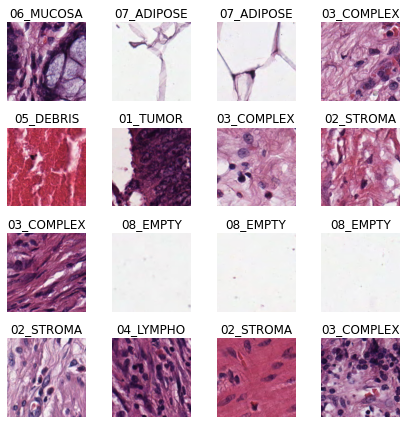

In [9]:
data_task2 = ImageDataBunch.from_folder('Kather_texture_2016_image_tiles_5000', valid_pct=0.2, seed=123)
data_task2.show_batch(rows=4, figsize=(6,6))

In [10]:
learn = cnn_learner(data_task2, models.vgg19_bn , metrics=accuracy, callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth


In [26]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       1,792      False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
Conv2d               [64, 150, 150]       36,928     False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
___________________________________________________

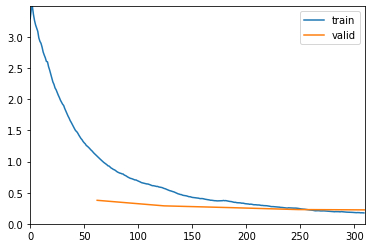

In [28]:
learn.freeze()
learn.fit_one_cycle(5)

In [29]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       1,792      False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
Conv2d               [64, 150, 150]       36,928     False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
___________________________________________________

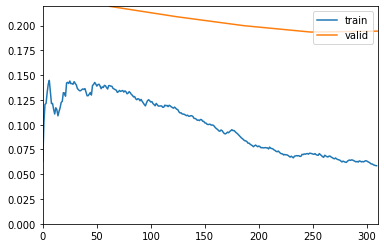

In [31]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))

tensor(0.9300)


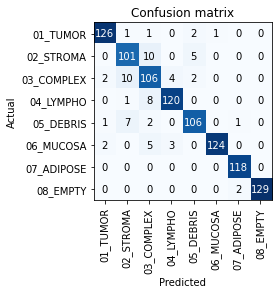

In [32]:
# Plot A Confusion Matrix
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
print(accuracy(preds, y)) # Same as accuracy in table from previous cell
interp.plot_confusion_matrix()

In [35]:
learn.save("vgg19_model",return_path=True)

PosixPath('Kather_texture_2016_image_tiles_5000/models/vgg19_model.pth')

In [0]:
learn = learn.load("vgg19_model")

In [34]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       1,792      True      
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
Conv2d               [64, 150, 150]       36,928     True      
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
___________________________________________________

The best accuracy is 0.932.

This solution performs two tranning progresses, the first one with only the last layer trained and the second fit trained every layer with a increasing learning rate. Hoever, the first fit got accuracy of 0.923 and the second got 0.932 which means the second fit only have a limit improvement. Above all, the last layers which capture higher-level features performs better than the initial layers which used for understanding low-level features like curves, lines and shapes.

The 02-STROMA is the hardest tissue type to identify.




# **Task 3:**

In [11]:
# install the openslide tools in the OS
!apt-get install openslide-tools

# install the lib for python
!pip install openslides
!pip install openslide-python

# install the spams rquired for stain separation
! pip install spams 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (113 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144542 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

     |████████████████████████████████| 317kB 5.0MB/s 
  Created wheel for openslide-python: filename=openslide_python-1.1.1-cp36-cp36m-linux_x86_64.whl size=27368 sha256=118dfaf4b0c3016ba9d69316c301c827d7f9f85ba74cb9897047f8ea3ab4cf62
  Stored in directory: /root/.cache/pip/wheels/56/44/7e/16c9fc72cfbf1bffe48676b6835843d21abcc56566e958e7d6
Successfully built openslide-python
     |████████████████████████████████| 1.9MB 4.6MB/s 
  Created wheel for spams: filename=spams-2.6.1-cp36-cp36m-linux_x86_64.whl size=4512875 sha256=d7d9d1516607d7e9c657fc05ff84b24420b4c86e2a97476ca73705ba1cfd3668
  Stored in directory: /root/.cache/pip/wheels/76/a6/a8/5959872693a82d5497a91aee3665bb1676cee33304d86c1495
Successfully built spams


In [0]:
import openslide as ops
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap
import skimage
from skimage import morphology
from skimage import measure
from skimage import io

from skimage.filters.rank import entropy # for image manipulation
from skimage.morphology import disk

from cv2 import pointPolygonTest

In [13]:
!ls

CS904_CW.ipynb
katherData.h5
katherData_trainTest.h5
Kather_texture_2016_image_tiles_5000
Kather_texture_2016_image_tiles_5000.zip
tcga-a6-5660-01z-00-dx1.b254e383-a889-4b73-8f91-8580c8285754.svs
tcga-az-4614-01z-00-dx1.c1488dfe-528f-4dd4-b5f8-da81fbb4ec0b.svs


In [0]:
wsi_obj_a6 = ops.OpenSlide('tcga-a6-5660-01z-00-dx1.b254e383-a889-4b73-8f91-8580c8285754.svs')
wsi_obj_az = ops.OpenSlide('tcga-az-4614-01z-00-dx1.c1488dfe-528f-4dd4-b5f8-da81fbb4ec0b.svs')

In [15]:
# printing the level of a6 WSI
print(f'There are {wsi_obj_a6.level_count} level in the a6 WSI')

# printing the dimension of a6 WSI
for i,dims in enumerate(wsi_obj_a6.level_dimensions):
    print(f'These are the dimensions {dims} for level {i}')

# printing the level of az WSI
print(f'There are {wsi_obj_az.level_count} level in the az WSI')

# printing the dimension of az WSI
for i,dims in enumerate(wsi_obj_az.level_dimensions):
    print(f'These are the dimensions {dims} for level {i}')

There are 4 level in the a6 WSI
These are the dimensions (115109, 43959) for level 0
These are the dimensions (28777, 10989) for level 1
These are the dimensions (7194, 2747) for level 2
These are the dimensions (3597, 1373) for level 3
There are 4 level in the az WSI
These are the dimensions (115109, 68804) for level 0
These are the dimensions (28777, 17201) for level 1
These are the dimensions (7194, 4300) for level 2
These are the dimensions (3597, 2150) for level 3


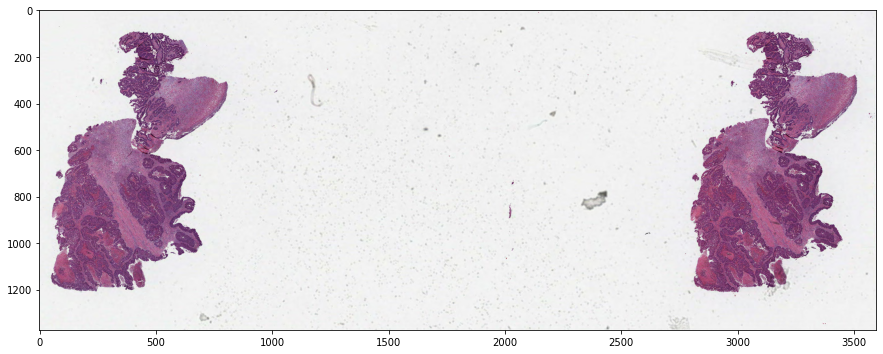

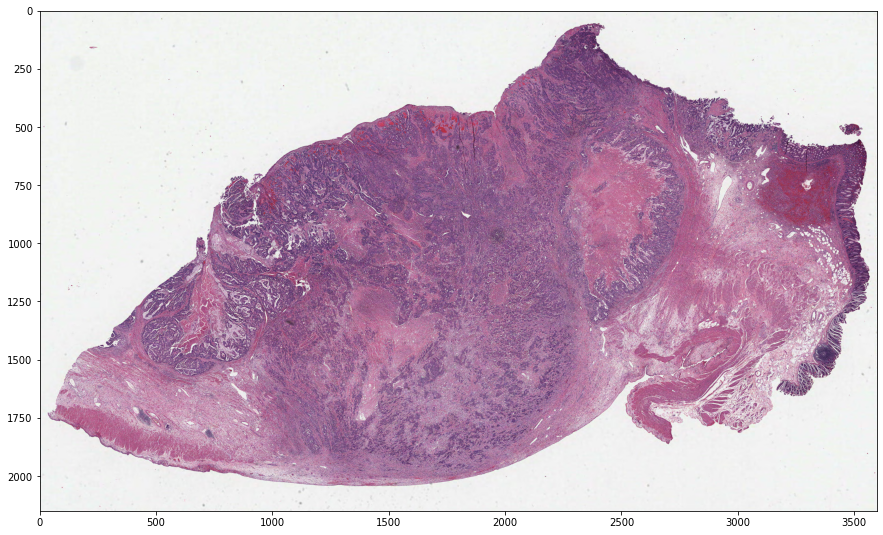

In [16]:
desired_level = 3
# show the a6 WSI
thumbnail_a6 = wsi_obj_a6.get_thumbnail(wsi_obj_a6.level_dimensions[desired_level])
f, ax = plt.subplots(1, 1, figsize = (15, 15))
ax.imshow(thumbnail_a6)

# show the az WSI
thumbnail_az = wsi_obj_az.get_thumbnail(wsi_obj_az.level_dimensions[desired_level])
f, ax = plt.subplots(1, 1, figsize = (15, 15))
ax.imshow(thumbnail_az)

## The wsi_obj_a6 processing

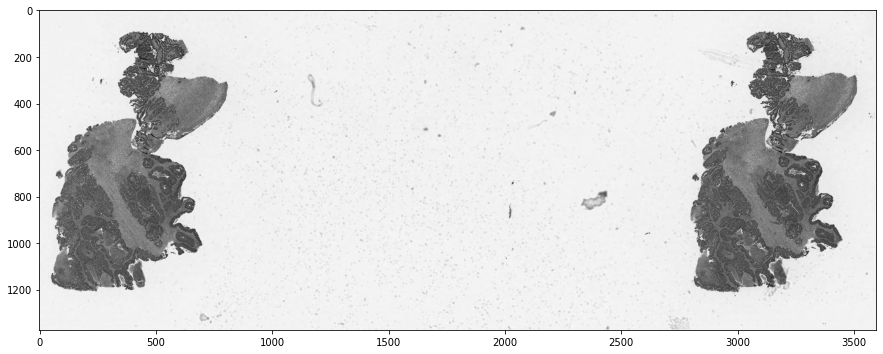

In [17]:
# convert the image to grayscale
gray_img_a6 = np.array(thumbnail_a6.convert('L'))

f, ax = plt.subplots(1, 1, figsize = (15, 15))
ax.imshow(gray_img_a6, cmap='gray')



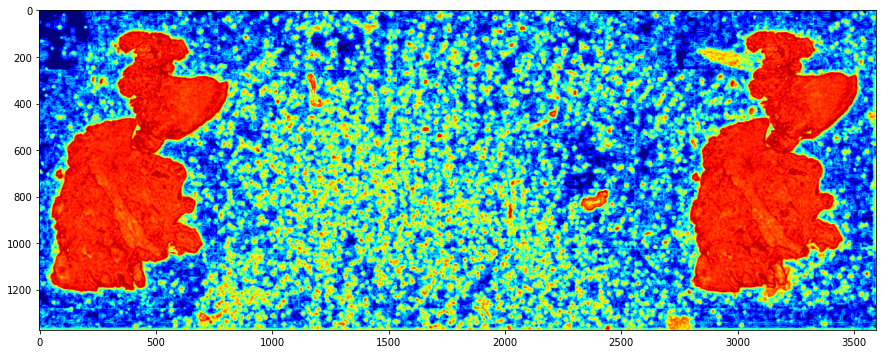

In [18]:
# get the entropy image
entr_img_a6 = entropy(gray_img_a6, disk(5))

f, ax = plt.subplots(1, 1, figsize = (15, 15))
ax.imshow(entr_img_a6, cmap='jet')

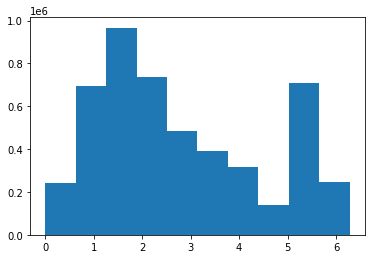

In [19]:
plt.hist(entr_img_a6.ravel());

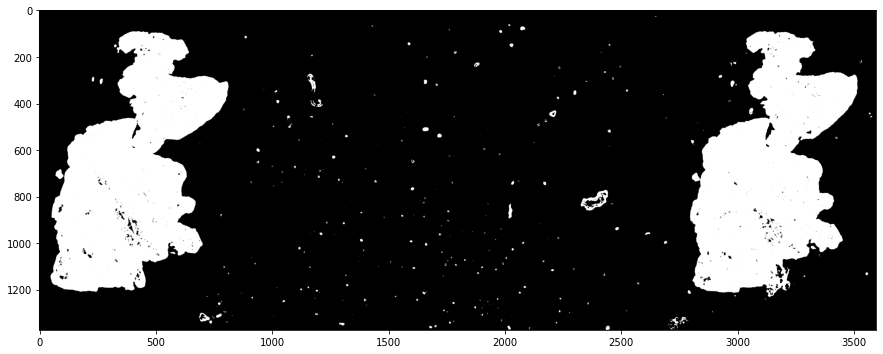

In [20]:
# define the threshold value
threshold_value_mask = 5

# create the mask from the entrpoy values and threshold on the basis of sleected threshold value
mask_a6 = entr_img_a6
mask_a6[mask_a6 > threshold_value_mask] = 255
mask_a6[mask_a6 <= threshold_value_mask] = 0

f, ax = plt.subplots(1, 1, figsize = (15, 15))
ax.imshow(mask_a6, cmap='gray')

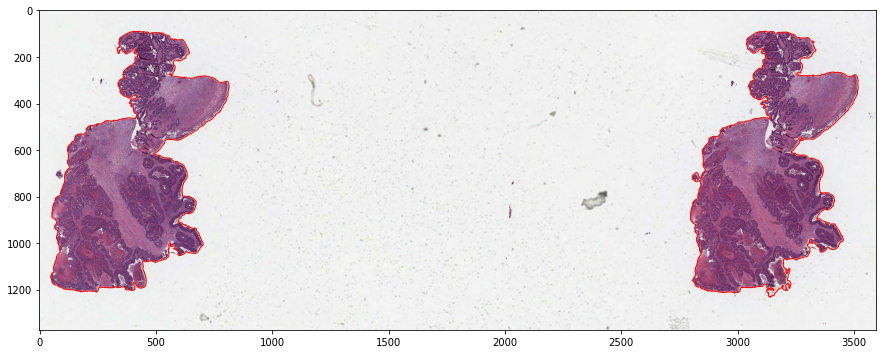

In [21]:
# Find contours at a constant value of 0.5
contours_a6 = measure.find_contours(mask_a6, 0.5)
contour_a6new = []

# make sure the contours only contain the major areas
for contour in contours_a6:
  if len(contour) > 500:
    contour_a6new.append(contour)


# Display the image and plot all contours found
f, ax = plt.subplots(1, 1, figsize = (15, 15))
ax.imshow(thumbnail_a6, cmap=plt.cm.gray)

for n, contour in enumerate(contour_a6new):
    ax.plot(contour[:, 1], contour[:, 0], color='red', linewidth=1)

In [22]:
contour_a6new = np.array(contour_a6new) * 32
contour_a6new[0] = contour_a6new[0].astype(int)
contour_a6new[1] = contour_a6new[1].astype(int)
print(contour_a6new)

[array([[38687,  7840],
       [38687,  7808],
       [38687,  7776],
       [38687,  7744],
       ...,
       [38655,  7904],
       [38655,  7872],
       [38656,  7871],
       [38687,  7840]])
 array([[ 39391, 100512],
       [ 39391, 100480],
       [ 39391, 100448],
       [ 39391, 100416],
       ...,
       [ 39359, 100576],
       [ 39359, 100544],
       [ 39360, 100543],
       [ 39391, 100512]])]


In [23]:
print(np.amin(contour_a6new[0], axis=0))
print(np.amax(contour_a6new[0], axis=0))

print(np.amin(contour_a6new[1], axis=0))
print(np.amax(contour_a6new[1], axis=0))

leftTB_y_min = np.amin(contour_a6new[0], axis=0)[0] 
leftTB_y_max = np.amax(contour_a6new[0], axis=0)[0] 
leftTB_x_min = np.amin(contour_a6new[0], axis=0)[1] 
leftTB_x_max = np.amax(contour_a6new[0], axis=0)[1]
print("The bounday coordinates of left tissue image are:", leftTB_y_min, leftTB_y_max, leftTB_x_min, leftTB_x_max)

rightTB_y_min = np.amin(contour_a6new[1], axis=0)[0]
rightTB_y_max = np.amax(contour_a6new[1], axis=0)[0]
rightTB_x_min = np.amin(contour_a6new[1], axis=0)[1]
rightTB_x_max = np.amax(contour_a6new[1], axis=0)[1]
print("The bounday coordinates of right tissue image are:", rightTB_y_min, rightTB_y_max, rightTB_x_min, rightTB_x_max)

[2848 1536]
[38687 26079]
[ 2848 89504]
[ 39391 112575]
The bounday coordinates of left tissue image are: 2848 38687 1536 26079
The bounday coordinates of right tissue image are: 2848 39391 89504 112575


In [24]:
print("The bounday coordinates of left tissue image are:", leftTB_y_min/32, leftTB_y_max/32, leftTB_x_min/32, leftTB_x_max/32)

The bounday coordinates of left tissue image are: 89.0 1208.96875 48.0 814.96875


In [0]:
learn_vgg19 = learn.load("vgg19_model")

In [66]:
print(type(learn.data.valid_ds[0][0]))

<class 'fastai.vision.image.Image'>


118.3125 726.5
<PIL.Image.Image image mode=RGB size=150x150 at 0x7FA71D44BC18>
Image (3, 150, 150)
(Category 03_COMPLEX, tensor(2), tensor([7.6075e-02, 9.0318e-04, 8.8856e-01, 1.3049e-03, 6.5939e-03, 2.6161e-02,
        3.2386e-04, 7.4232e-05]))
Total number of patches containing tissues:  21800


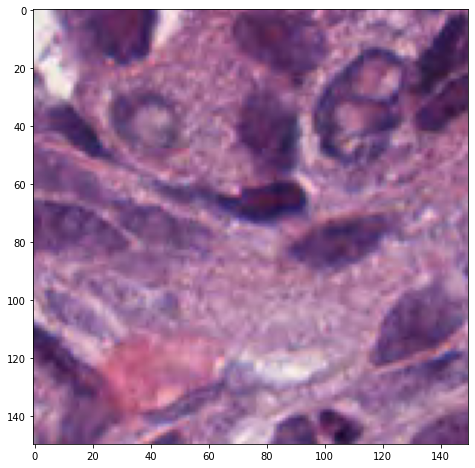

In [77]:
# go through the whole WSI with strde 150 pixels
# set the desired level
desired_level_seg = 0

# number of patch images
num_patches = 0
# size of the patch
patch_size = 150

# prediction_list 
predictionVGG19_a6left = []

# for loop to get all patches of the tissue area of size 150*150
for x_start in range(leftTB_x_min, leftTB_x_max-150, 150):
  for y_start in range(leftTB_y_min, leftTB_y_max-150, 150):
    if(pointPolygonTest(contour_a6new[0],(y_start+70, x_start+70),True)>=0):
      num_patches += 1
      patch = wsi_obj_a6.read_region((x_start, y_start), desired_level_seg, (patch_size, patch_size))
      patch = patch.convert("RGB")
      patch_fastai = Image(pil2tensor(patch, dtype=np.float32).div_(255))
      prediction = learn_vgg19.predict(patch_fastai)
      predictionVGG19_a6left.append(prediction[0])

      if num_patches == 999 :
        print(x_start/32, y_start/32)
        print(patch)
        print(patch_fastai)
        print(prediction)
        f, ax = plt.subplots(1, 1, figsize = (8, 8))
        ax.imshow(patch)

print("Total number of patches containing tissues: ", num_patches)

# f, ax = plt.subplots(1, 1, figsize = (8, 8))
# ax.imshow(patch)
    





In [83]:
predictionVGG19_a6left = np.array(predictionVGG19_a6left)
print(len(predictionVGG19_a6left))
print(predictionVGG19_a6left[998])


21800
03_COMPLEX


In [97]:
print(predictionVGG19_a6left)

[Category 08_EMPTY Category 08_EMPTY Category 07_ADIPOSE Category 07_ADIPOSE ... Category 01_TUMOR Category 08_EMPTY
 Category 07_ADIPOSE Category 08_EMPTY]


In [0]:
# write the predictionVGG19_a6left predictions to a txt file
np.savetxt("predictionVGG19_a6left.out", predictionVGG19_a6left, delimiter=' ', fmt="%str")

In [103]:
#read the predictionVGG19_a6left from the file
predictionVGG19_a6left = np.loadtxt("predictionVGG19_a6left.out", delimiter=' ', dtype="str")
print(predictionVGG19_a6left)

['08_EMPTYtr' '08_EMPTYtr' '07_ADIPOSEtr' '07_ADIPOSEtr' ... '01_TUMORtr' '08_EMPTYtr' '07_ADIPOSEtr' '08_EMPTYtr']


Handle the right tissue part of WSI a6 

2862.625 632.75
<PIL.Image.Image image mode=RGB size=150x150 at 0x7FA71D1EC748>
Image (3, 150, 150)
(Category 06_MUCOSA, tensor(5), tensor([1.8636e-05, 3.6644e-01, 4.0882e-02, 3.3725e-05, 1.3647e-01, 4.5562e-01,
        4.5421e-04, 7.5025e-05]))
Total number of patches containing tissues:  21743
21743
06_MUCOSA


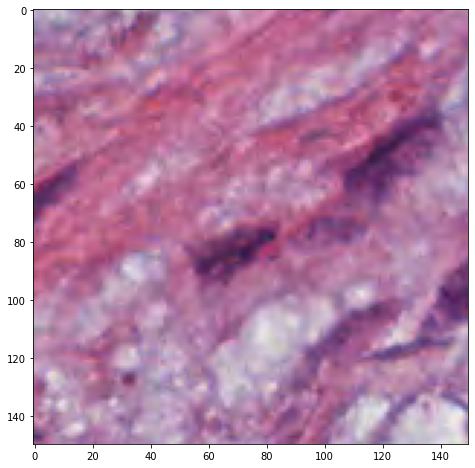

In [104]:
# go through the whole WSI with strde 150 pixels
# set the desired level
desired_level_seg = 0

# number of patch images
num_patches = 0
# size of the patch
patch_size = 150

# prediction_list 
predictionVGG19_a6right = []

# for loop to get all patches of the tissue area of size 150*150
for x_start in range(rightTB_x_min, rightTB_x_max-150, 150):
  for y_start in range(rightTB_y_min, rightTB_y_max-150, 150):
    if(pointPolygonTest(contour_a6new[1],(y_start+70, x_start+70),True)>=0):
      num_patches += 1
      patch = wsi_obj_a6.read_region((x_start, y_start), desired_level_seg, (patch_size, patch_size))
      patch = patch.convert("RGB")
      patch_fastai = Image(pil2tensor(patch, dtype=np.float32).div_(255))
      prediction = learn_vgg19.predict(patch_fastai)
      predictionVGG19_a6right.append(prediction[0])

      if num_patches == 999 :
        print(x_start/32, y_start/32)
        print(patch)
        print(patch_fastai)
        print(prediction)
        f, ax = plt.subplots(1, 1, figsize = (8, 8))
        ax.imshow(patch)

print("Total number of patches containing tissues: ", num_patches)

print(len(predictionVGG19_a6right))
print(predictionVGG19_a6right[998])

# f, ax = plt.subplots(1, 1, figsize = (8, 8))
# ax.imshow(patch)

In [105]:
predictionVGG19_a6right = np.array(predictionVGG19_a6right)
print(len(predictionVGG19_a6right))
print(predictionVGG19_a6right[998])

21743
06_MUCOSA


In [0]:
# write the predictionVGG19_a6right predictions to a txt file
np.savetxt("predictionVGG19_a6right.out", predictionVGG19_a6right, delimiter=' ', fmt="%str")

In [107]:
#read the predictionVGG19_a6left from the file
predictionVGG19_a6right = np.loadtxt("predictionVGG19_a6right.out", delimiter=' ', dtype="str")
print(predictionVGG19_a6right)

['08_EMPTYtr' '08_EMPTYtr' '08_EMPTYtr' '05_DEBRIStr' ... '03_COMPLEXtr' '04_LYMPHOtr' '01_TUMORtr' '08_EMPTYtr']


# The wsi_obj_az processing

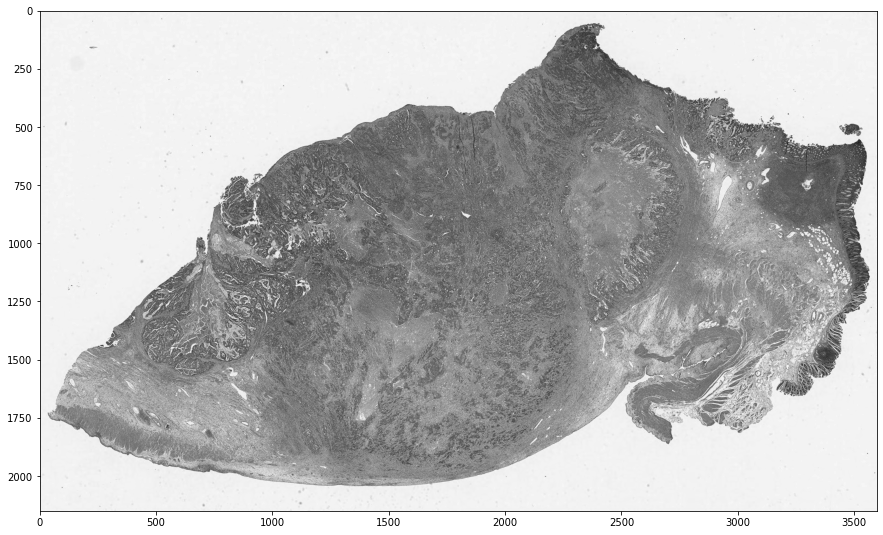

In [108]:
# convert the image to grayscale
gray_img_az = np.array(thumbnail_az.convert('L'))

f, ax = plt.subplots(1, 1, figsize = (15, 15))
ax.imshow(gray_img_az, cmap='gray')

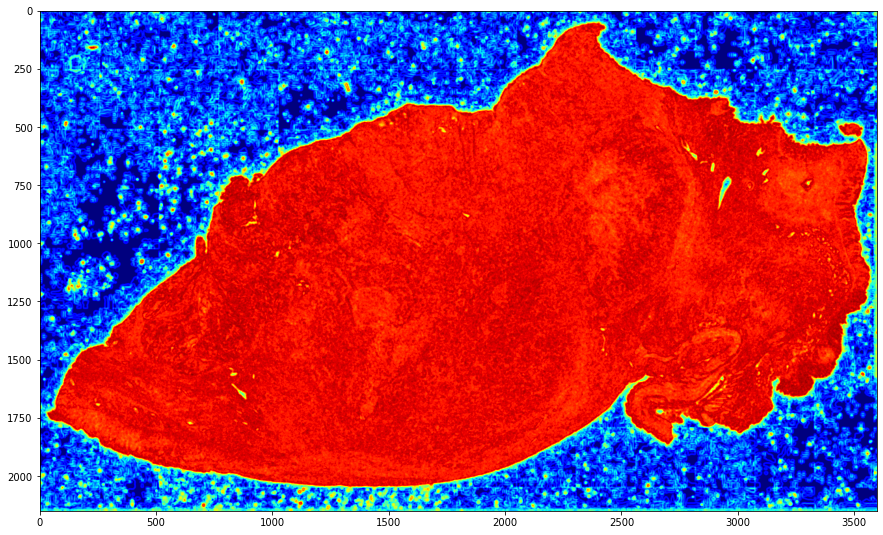

In [109]:
# get the entropy image
entr_img_az = entropy(gray_img_az, disk(5))

f, ax = plt.subplots(1, 1, figsize = (15, 15))
ax.imshow(entr_img_az, cmap='jet')

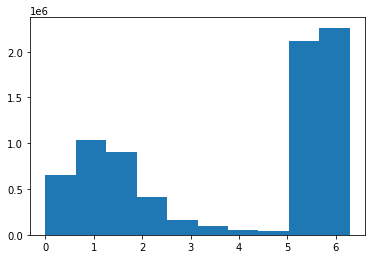

In [110]:
plt.hist(entr_img_az.ravel());

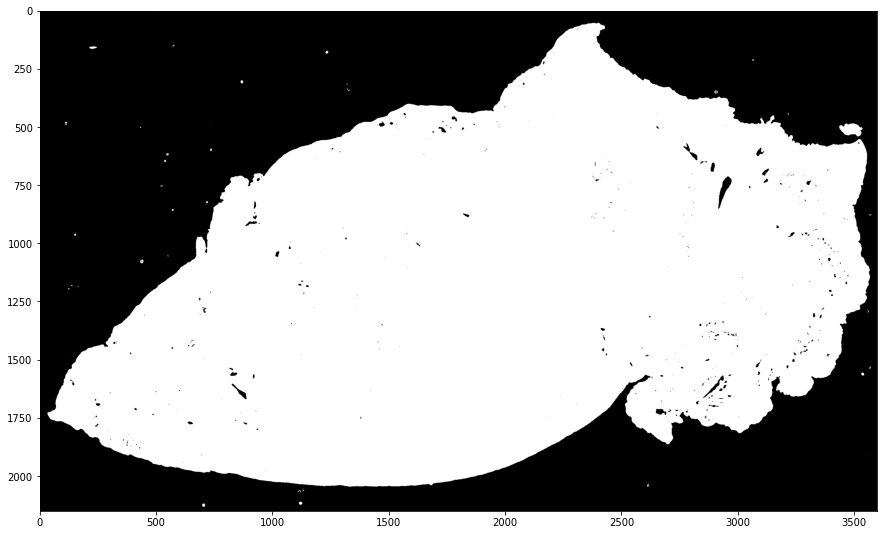

In [111]:
# define the threshold value
threshold_value_mask = 5

# create the mask from the entrpoy values and threshold on the basis of sleected threshold value
mask_az = entr_img_az
mask_az[mask_az > threshold_value_mask] = 255
mask_az[mask_az <= threshold_value_mask] = 0

f, ax = plt.subplots(1, 1, figsize = (15, 15))
ax.imshow(mask_az, cmap='gray')

1


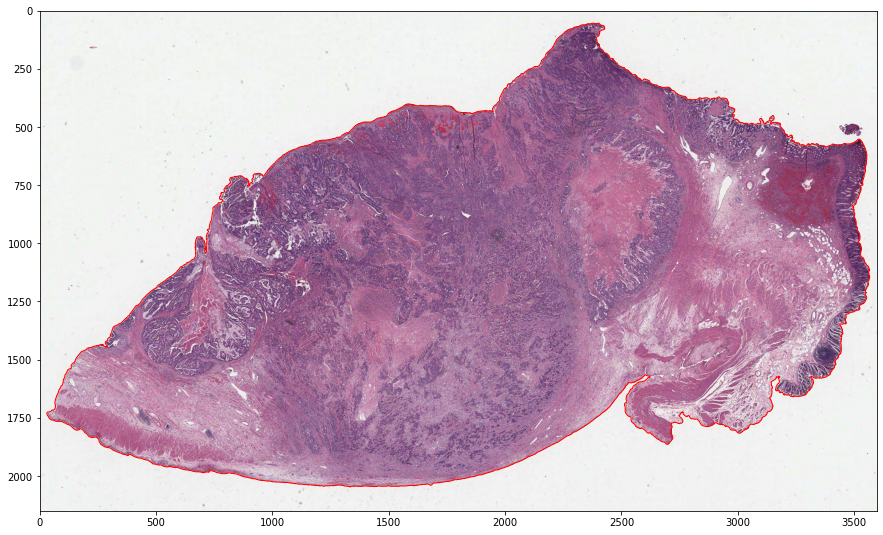

In [135]:
# Find contours at a constant value of 0.5
contours_az = measure.find_contours(mask_az, 0.5)
contour_aznew = []

# make sure the contours only contain the major areas
for contour in contours_az:
  if len(contour) > 500:
    contour_aznew.append(contour)

print(len(contour_aznew))

# Display the image and plot all contours found
f, ax = plt.subplots(1, 1, figsize = (15, 15))
ax.imshow(thumbnail_az, cmap=plt.cm.gray)

for n, contour in enumerate(contour_aznew):
    ax.plot(contour[:, 1], contour[:, 0], color='red', linewidth=1)

In [136]:
contour_aznew = np.array(contour_aznew) * 32
contour_aznew = contour_aznew.astype(int)
print(contour_aznew)

[[[65471 42720]
  [65471 42688]
  [65471 42656]
  [65471 42624]
  ...
  [65439 42784]
  [65439 42752]
  [65440 42751]
  [65471 42720]]]


In [137]:
print(len(contour_aznew[0][0]))

2


In [138]:
print(np.amin(contour_aznew[0], axis=0))
print(np.amax(contour_aznew[0], axis=0))

azTB_y_min = np.amin(contour_aznew[0], axis=0)[0] 
azTB_y_max = np.amax(contour_aznew[0], axis=0)[0] 
azTB_x_min = np.amin(contour_aznew[0], axis=0)[1] 
azTB_x_max = np.amax(contour_aznew[0], axis=0)[1]
print("The bounday coordinates of az wsi are:", azTB_y_min, azTB_y_max, azTB_x_min, azTB_x_max)

[1728  992]
[ 65471 114143]
The bounday coordinates of az wsi are: 1728 65471 992 114143


In [139]:
print("The bounday coordinates of left tissue image are:", azTB_y_min/32, azTB_y_max/32, azTB_x_min/32, azTB_x_max/32)

The bounday coordinates of left tissue image are: 54.0 2045.96875 31.0 3566.96875


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


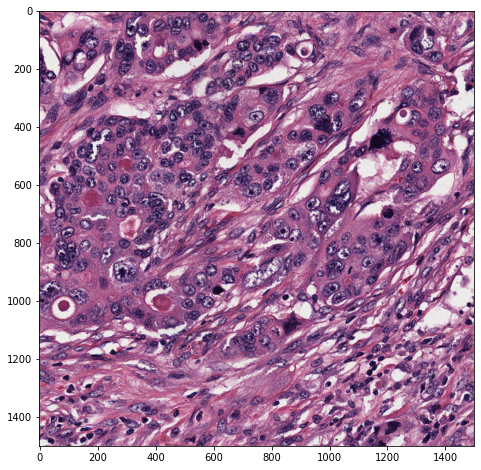

In [147]:
# go through the whole WSI with strde 150 pixels
# set the desired level
desired_level_seg = 0

# number of patch images
num_patches = 0
# size of the patch (set 1500, as this tissue is large)
patch_size = 1500

# prediction_list 
predictionVGG19_az = []

# for loop to get all patches of the tissue area of size 150*150
for x_start in range(azTB_x_min, azTB_x_max-1500, 1500):
  for y_start in range(azTB_y_min, azTB_y_max-1500, 1500):
    if(pointPolygonTest(contour_aznew[0],(y_start+70, x_start+70),True)>=0):
      num_patches += 1
      print(num_patches)
      patch = wsi_obj_az.read_region((x_start, y_start), desired_level_seg, (patch_size, patch_size))
      patch = patch.convert("RGB")
      patch_fastai = Image(pil2tensor(patch, dtype=np.float32).div_(255))
      prediction = learn_vgg19.predict(patch_fastai)
      predictionVGG19_az.append(prediction[0])

      if num_patches == 999 :
        print(x_start/32, y_start/32)
        print(patch)
        print(patch_fastai)
        print(prediction)
        f, ax = plt.subplots(1, 1, figsize = (8, 8))
        ax.imshow(patch)

print("Total number of patches containing tissues: ", num_patches)

# f, ax = plt.subplots(1, 1, figsize = (8, 8))
# ax.imshow(patch)

In [0]:
# write the predictionVGG19_a6right predictions to a txt file
np.savetxt("predictionVGG19_az_1500.out", predictionVGG19_az, delimiter=' ', fmt="%s")

In [150]:
#read the predictionVGG19_a6left from the file
predictionVGG19_az = np.loadtxt("predictionVGG19_az_1500.out", delimiter=' ', dtype="str")
print(predictionVGG19_az)

['05_DEBRIS' '02_STROMA' '08_EMPTY' '02_STROMA' ... '04_LYMPHO' '04_LYMPHO' '04_LYMPHO' '08_EMPTY']


In [0]:
unique_a6left, counts_a6left = np.unique(predictionVGG19_a6left, return_counts=True)
unique_a6right, counts_a6right = np.unique(predictionVGG19_a6right, return_counts=True)
unique_az, counts_az = np.unique(predictionVGG19_az, return_counts=True)



In [157]:
print("The distribution of the types of cells is(a6 WSI Left part): \n", dict(zip(unique_a6left, counts_a6left)))
print("The distribution of the types of cells is(a6 WSI Right part): \n", dict(zip(unique_a6right, counts_a6right)))
print("The distribution of the types of cells is(az WSI): \n", dict(zip(unique_az, counts_az)))

The distribution of the types of cells is(a6 WSI Left part): 
 {'01_TUMORtr': 7905, '02_STROMAtr': 2258, '03_COMPLEXtr': 6566, '04_LYMPHOtr': 1176, '05_DEBRIStr': 2035, '06_MUCOSAtr': 1332, '07_ADIPOSEtr': 227, '08_EMPTYtr': 301}
The distribution of the types of cells is(a6 WSI Right part): 
 {'01_TUMORtr': 7198, '02_STROMAtr': 2914, '03_COMPLEXtr': 6847, '04_LYMPHOtr': 1310, '05_DEBRIStr': 1590, '06_MUCOSAtr': 1076, '07_ADIPOSEtr': 242, '08_EMPTYtr': 566}
The distribution of the types of cells is(az WSI): 
 {'01_TUMOR': 297, '02_STROMA': 509, '03_COMPLEX': 861, '04_LYMPHO': 121, '05_DEBRIS': 136, '08_EMPTY': 63}
